In [1]:
import pandas as pd
penguins = pd.read_csv('penguins.csv')
penguins.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0


In [2]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CulmenLength   342 non-null    float64
 1   CulmenDepth    342 non-null    float64
 2   FlipperLength  342 non-null    float64
 3   BodyMass       342 non-null    float64
 4   Species        344 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 13.6 KB


In [3]:
penguins.isnull().sum()

CulmenLength     2
CulmenDepth      2
FlipperLength    2
BodyMass         2
Species          0
dtype: int64

In [4]:
penguins = penguins.dropna()

In [5]:
penguins.describe()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
count,342.000000,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386,0.757310
std,5.459584,1.974793,14.061714,801.954536,0.763648
min,32.100000,13.100000,172.000000,2700.000000,0.000000
25%,39.225000,15.600000,190.000000,3550.000000,0.000000
50%,44.450000,17.300000,197.000000,4050.000000,1.000000
75%,48.500000,18.700000,213.000000,4750.000000,1.000000
max,59.600000,21.500000,231.000000,6300.000000,2.000000


In [6]:
penguins.FlipperLength = penguins.FlipperLength/10
penguins.BodyMass = penguins.BodyMass/100

In [7]:
for i in range(1, 3):
    penguins = penguins.append(penguins)

In [8]:
sample = penguins.sample(10)

In [9]:
penguin_classes = ['Adelie', 'Gentoo', 'Chinstrap']
print(sample.columns[0:5].values, 'SpeciesName')
for index, row in penguins.sample(10).iterrows():
    print('[',row[0], row[1], row[2],row[3], int(row[4]), ']',penguin_classes[int(row[-1])])

['CulmenLength' 'CulmenDepth' 'FlipperLength' 'BodyMass' 'Species'] SpeciesName
[ 40.9 16.8 19.1 37.0 0 ] Adelie
[ 37.6 19.3 18.1 33.0 0 ] Adelie
[ 39.6 17.2 19.6 35.5 0 ] Adelie
[ 40.9 18.9 18.4 39.0 0 ] Adelie
[ 40.5 17.9 18.7 32.0 0 ] Adelie
[ 48.2 15.6 22.1 51.0 1 ] Gentoo
[ 42.0 19.5 20.0 40.5 0 ] Adelie
[ 52.1 17.0 23.0 55.5 1 ] Gentoo
[ 41.1 18.2 19.2 40.5 0 ] Adelie
[ 39.5 16.7 17.8 32.5 0 ] Adelie


In [10]:
from sklearn.model_selection import train_test_split
features = list(penguins.columns.values[:-1])
label = penguins.columns.values[-1]
print(features)
print(label)
X_train, X_test, y_train, y_test = train_test_split(penguins[features].values, penguins[label].values, test_size=0.3, random_state=0)

['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']
Species


In [11]:
import torch 
import torch.nn as nn
import torch.utils.data as td

torch.manual_seed(0)
print(torch.__version__)

1.9.0.post2


In [12]:
train_x = torch.Tensor(X_train).float()
tran_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x, tran_y)
train_loader = td.DataLoader(train_ds, batch_size=20, shuffle=False, num_workers=1)

test_x = torch.Tensor(X_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=20, shuffle=False, num_workers=1)

In [13]:
hl = 10

class PenguinNet(nn.Module):
    def __init__(self):
        super(PenguinNet, self).__init__()
        self.fc1 = nn.Linear(len(features), hl)
        self.fc2 = nn.Linear(hl, hl)
        self.fc3 = nn.Linear(hl, len(penguin_classes))
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        return x

model = PenguinNet()
print(model)

PenguinNet(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)


In [14]:
def train(data_loader, model, loss_fn, optimizer):
    # set the model to training mode
    model.train()
    train_loss = 0
    
    for batch, (X, y) in enumerate(data_loader):
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_loss = train_loss/(batch+1)
    print(f'Train Average loss {avg_loss}')
    return avg_loss

In [15]:
def test(data_loader, model, loss_fn):
    # set the model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        batch_count = 0
        for batch, (X, y) in enumerate(data_loader):
            batch_count += 1
            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item()
            
            _, predicted = torch.max(pred.data, 1)
            correct += torch.sum(y==predicted).item()
    avg_loss = test_loss / batch_count
    print(f'Test Average loss {avg_loss}, Accuracy {correct}/{len(data_loader.dataset)} = {correct/len(data_loader.dataset)}')
    return avg_loss

In [16]:
loss_criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
epoch_nums = []
training_loss = []
validation_loss = []


epochs = 50
for epoch in range(1, epochs + 1):

    print('Epoch: {}'.format(epoch))
    
    train_loss = train(train_loader, model, loss_criteria, optimizer)
    
    test_loss = test(test_loader, model, loss_criteria)

    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Train Average loss 1.0914984916647275
Test Average loss 1.02553406499681, Accuracy 246/411 = 0.5985401459854015
Epoch: 2
Train Average loss 1.0009490872422855
Test Average loss 0.9824494889804295, Accuracy 314/411 = 0.7639902676399026
Epoch: 3
Train Average loss 0.9539049789309502
Test Average loss 0.9379085415885562, Accuracy 321/411 = 0.781021897810219
Epoch: 4
Train Average loss 0.9067416662971178
Test Average loss 0.8931661361739749, Accuracy 322/411 = 0.7834549878345499
Epoch: 5
Train Average loss 0.8602620090047518
Test Average loss 0.8530265887578329, Accuracy 322/411 = 0.7834549878345499
Epoch: 6
Train Average loss 0.8189095159371694
Test Average loss 0.8167579968770345, Accuracy 323/411 = 0.7858880778588808
Epoch: 7
Train Average loss 0.7832467916111151
Test Average loss 0.7825750907262167, Accuracy 334/411 = 0.8126520681265207
Epoch: 8
Train Average loss 0.7503491354485353
Test Average loss 0.7488679516883123, Accuracy 353/411 = 0.8588807785888077
Epoch: 9
Train Aver

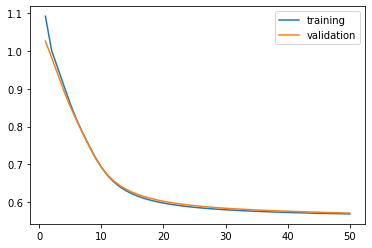

In [18]:
import matplotlib.pyplot as plt
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.legend(['training', 'validation'])
plt.show()

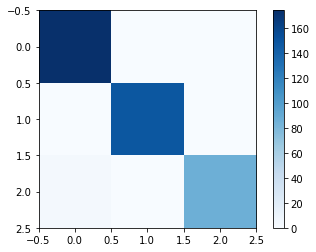

In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np
model.eval()

x = torch.Tensor(X_test).float()
_, predicted = torch.max(model(x).data, 1)

cm = confusion_matrix(y_test, predicted.numpy())
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.show()

In [20]:
model_file = 'penguin_classifier.pt'
torch.save(model.state_dict(), model_file)
#del model

In [31]:
x_new = np.array([[50.4, 15.3, 20, 50]])
# model = PenguinNet()
# model.load_state_dict(torch.load(model_file))
# model.eval()

# x = torch.Tensor(x_new).float()
# _, predicted = torch.max(model(x).data, 1)

In [22]:
X_train

array([[51.1, 16.5, 22.5, 52.5],
       [50.7, 19.7, 20.3, 40.5],
       [49.5, 16.2, 22.9, 58. ],
       ...,
       [48.7, 15.7, 20.8, 53.5],
       [46.2, 14.4, 21.4, 46.5],
       [39.1, 18.7, 18.1, 37.5]])

In [25]:
model.eval()
model(torch.tensor(X_train).float())

tensor([[9.7298e-05, 9.9907e-01, 8.3680e-04],
        [1.0505e-02, 1.5375e-03, 9.8796e-01],
        [3.0750e-05, 9.9997e-01, 1.6881e-06],
        ...,
        [2.7600e-05, 9.9990e-01, 6.7719e-05],
        [2.2333e-04, 9.9805e-01, 1.7292e-03],
        [9.9952e-01, 5.3397e-05, 4.2193e-04]], grad_fn=<SoftmaxBackward>)

In [32]:
model(torch.tensor(x_new).float())

tensor([[4.6631e-06, 9.9672e-01, 3.2777e-03]], grad_fn=<SoftmaxBackward>)